# Telegram ML competition 2023

Inspired by this article: https://arxiv.org/pdf/1509.01626.pdf

My approach assumes that the code snippets can be represented as a grid-like topology data so we can use CNN to find some patterns and classify programming language

### Word embeddings

I'm using one hot embeddings on the character level, so it is possible to represent text as a grid data for 1D CNNs

In [1]:
from common import *
from word_embeddings import *

In [2]:
print(f'This is the alphabet:\n{ALPHABET}')
print(f'Alphabet lenght: {ALPHABET_SIZE}')

This is the alphabet:
abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-,;.!?:"'/\|_@#$%ˆ&*+-=<>()[]{}
	 
Alphabet lenght: 96


In the `common.py` files labels are being defined (programming languages we are going to classify)

In [3]:
print(f'We have {CLASSES_NUM} classes')

We have 100 classes


In [4]:
fill_embeddings_map(ALPHABET)

### Dataset generation

I've found this solution on **Kaggle** for labeled code snippet dataset generation: https://www.kaggle.com/code/amalhasni/creating-labeled-code-snippets-dataset

In [5]:
from code_snippet_dataset import *

In [6]:
BATCH_SIZE = 8
CSV_FILE_PATH = 'lang_dataset.csv'

/Users/20633013/Desktop/code_snippet_clf/code_snippet_dataset.py:25: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


Dataset len: 187056
Encoded code snippet: torch.Size([8, 96, 1024])
Encoded code snippet label: torch.Size([8, 100])


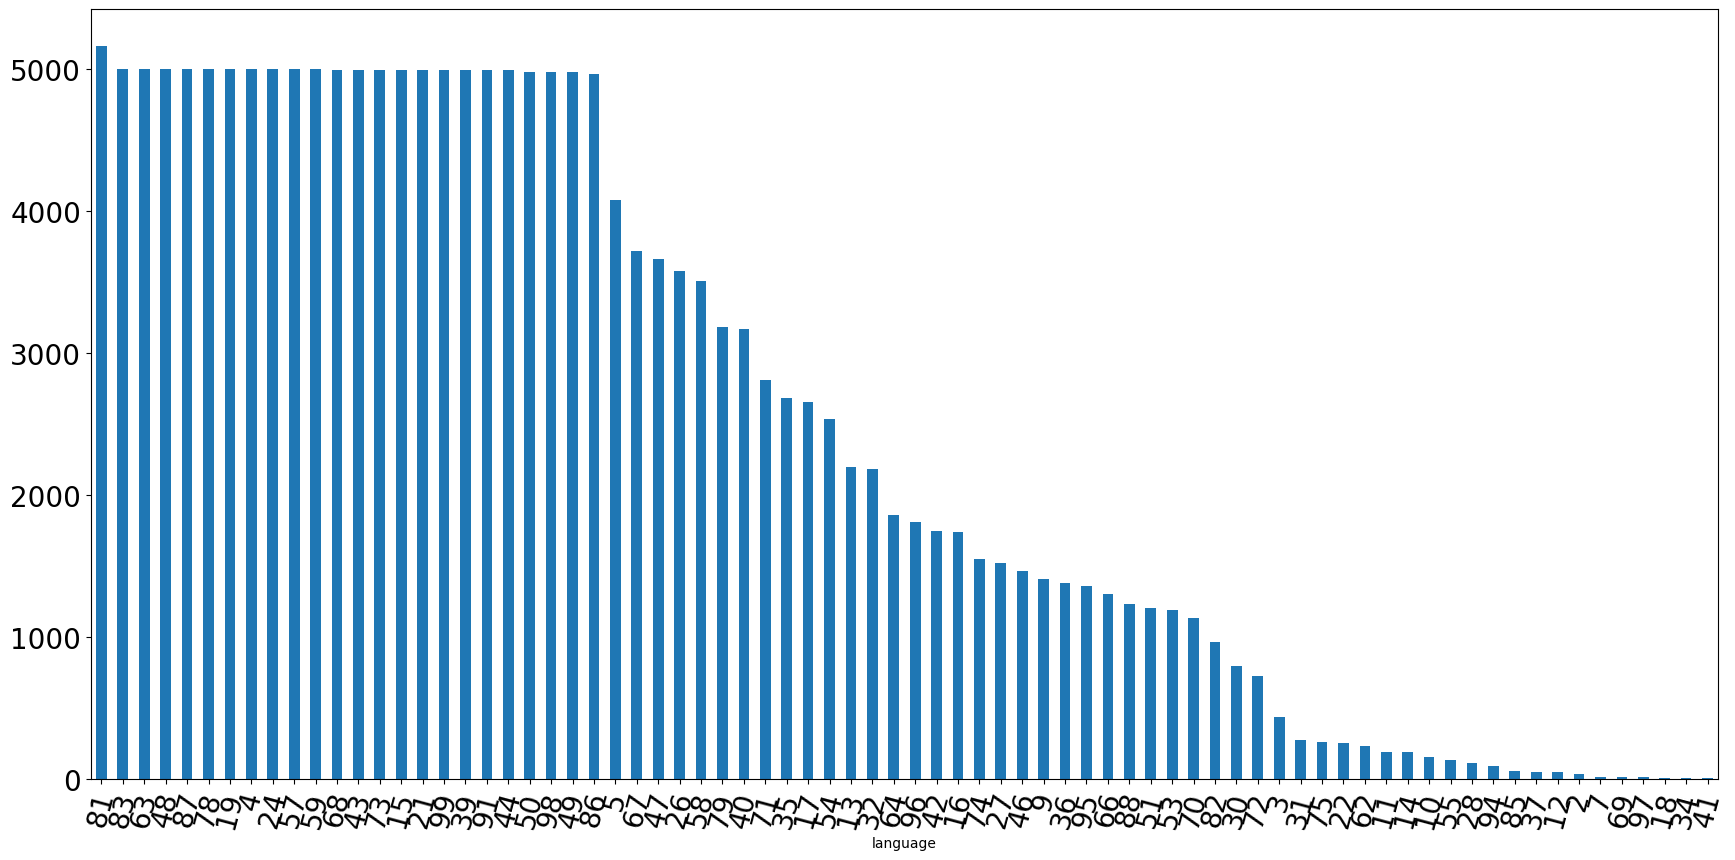

In [7]:
full_dataset = CodeSnippetDataset(CSV_FILE_PATH)
full_dataloader = torch.utils.data.DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=True)

real_batch = next(iter(full_dataloader))
print(f'Encoded code snippet: {real_batch[0].shape}')
print(f'Encoded code snippet label: {real_batch[1].shape}')

* On the **X axis** you can see programming language number (defined in `common.py`)
* On the **Y axis** you can see value count per language

### Split dataset on Train and Validation

In [8]:
from utils import *

In [9]:
val_size = 0.2
val_inds = subset_ind(full_dataset, 0.2)

In [10]:
train_dataset = Subset(full_dataset, [i for i in range(len(full_dataset)) if i not in val_inds])
val_dataset = Subset(full_dataset, val_inds)

print(f'train size: {len(train_dataset)}\nval size: {len(val_dataset)}')

train size: 149645
val size: 37411


In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

Okay, now we have some data for model training

lets move on 🤓

### Code snippet classification Model

In [12]:
from code_snippet_model import *

/Users/20633013/Desktop/Torch exp/torchenv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [13]:
model = CodeSnippetClf(ALPHABET_SIZE)
print(f'This is model arhutecture:\n\n{model}')

This is model arhutecture:

CodeSnippetClf(
  (conv1): Conv1d(96, 64, kernel_size=(3,), stride=(3,))
  (conv2): Conv1d(64, 32, kernel_size=(3,), stride=(3,))
  (conv3): Conv1d(32, 8, kernel_size=(3,), stride=(3,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=81, bias=True)
  (fc3): Linear(in_features=81, out_features=100, bias=True)
  (activation): Sigmoid()
)


As you can see, model consist of:

* 3 convolutional layers with pooling
* 3 fully connected layers and activation func

**How long does it works?🧐**

In [14]:
import time

random_input = torch.randn(1, 96, 1024) # Generate random input data

tic = time.perf_counter_ns()
output = model(random_input)
toc = time.perf_counter_ns()
runtime = (toc - tic) / 1000000
print(f'Model runtime on a single encoded snippet without pre/post processing is {runtime:0.4f} ms')

Model runtime on a single encoded snippet without pre/post processing is 5.4024 ms


Okay, `~2 ms` is fine, lets move to the train part

### Train model

In [15]:
EPOCHS = 10
LR = 1e-3

In [16]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [17]:
train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS)

Epoch 1/10. time: 14872.850s
train loss: 0.039110
val loss: 0.024836
validation acc: 0.532749


Epoch 2/10. time: 353.398s
train loss: 0.020908
val loss: 0.017063
validation acc: 0.685197


Epoch 3/10. time: 411.975s
train loss: 0.016323
val loss: 0.014365
validation acc: 0.740298


Epoch 4/10. time: 378.554s
train loss: 0.014508
val loss: 0.013633
validation acc: 0.756637


Epoch 5/10. time: 383.070s
train loss: 0.013457
val loss: 0.012714
validation acc: 0.770455


Epoch 6/10. time: 387.804s
train loss: 0.012846
val loss: 0.012454
validation acc: 0.774829


Epoch 7/10. time: 384.321s
train loss: 0.012392
val loss: 0.012035
validation acc: 0.784593


Epoch 8/10. time: 397.303s
train loss: 0.012043
val loss: 0.011932
validation acc: 0.785074


Epoch 9/10. time: 372.814s
train loss: 0.011804
val loss: 0.011904
validation acc: 0.788753


Epoch 10/10. time: 369.151s
train loss: 0.011591
val loss: 0.011940
validation acc: 0.787016




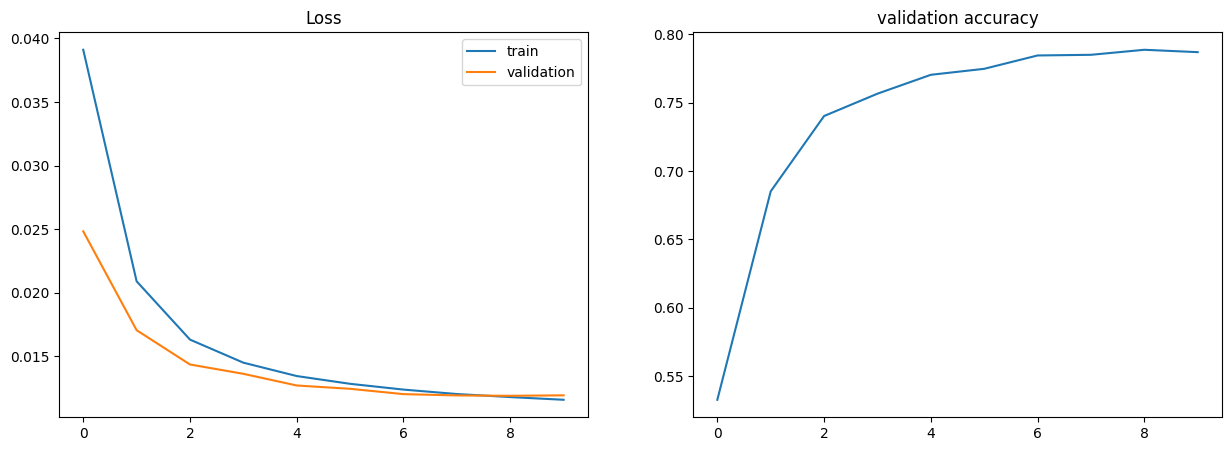

In [18]:
plot_train(train_loss, val_loss, val_accuracy)

### Test model with code snippet from my git repo

In [34]:
model = torch.load('code_snippet_clf_11.pht')

CodeSnippetClf(
  (conv1): Conv1d(96, 64, kernel_size=(3,), stride=(3,))
  (conv2): Conv1d(64, 32, kernel_size=(3,), stride=(3,))
  (conv3): Conv1d(32, 8, kernel_size=(3,), stride=(3,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=81, bias=True)
  (fc3): Linear(in_features=81, out_features=100, bias=True)
  (activation): Sigmoid()
)

In [21]:
code = """
Hi, check my code
import UIKit

class FeedTableViewCell: UITableViewCell {
    
    @IBOutlet var profileImage: UIImageView!
    @IBOutlet var nickLabel: UILabel!
    @IBOutlet var songNameLabel: UILabel!
    @IBOutlet var artistLabel: UILabel!
    @IBOutlet var albumLabel: UILabel!
    @IBOutlet var albumImage: UIImageView!


HAHAHHAHA
"""
embedded_sentence = get_embedded_sentence(code)
diff = TELEGRAM_MESSAGE_MAX_LEN - embedded_sentence.shape[1]
embedded_sentence = np.append(embedded_sentence, np.zeros((ALPHABET_SIZE, diff)), axis=1)
input_tensor = torch.tensor(embedded_sentence, dtype=torch.float32)

In [22]:
model.eval()
with torch.no_grad():
    output= model(input_tensor)
    print(f'This is {targets_desctiption[torch.argmax(output)]} with probability {output[0][torch.argmax(output)].item():2f}')

This is SWIFT with probability 0.333411


### Save to ONNX

In [89]:
import torch.onnx

In [90]:
model = torch.load('code_snippet_clf_11.pht')
model.eval()

CodeSnippetClf(
  (conv1): Conv1d(96, 64, kernel_size=(3,), stride=(3,))
  (conv2): Conv1d(64, 32, kernel_size=(3,), stride=(3,))
  (conv3): Conv1d(32, 8, kernel_size=(3,), stride=(3,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=81, bias=True)
  (fc3): Linear(in_features=81, out_features=100, bias=True)
  (activation): Sigmoid()
)

In [91]:
dummy_input = torch.randn(1, ALPHABET_SIZE, TELEGRAM_MESSAGE_MAX_LEN)
input_names = [ "input" ]
output_names = [ "output" ]

In [93]:
torch.onnx.export(model,
                 dummy_input,
                 "code_snippet_clf.onnx",
                 verbose=False,
                 input_names=input_names,
                 output_names=output_names,
                 export_params=True,
                 )

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



### Test ONNX inference

In [141]:
import onnxruntime as onnxrt
tic = time.perf_counter()
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

onnx_session= onnxrt.InferenceSession("code_snippet_clf.onnx")
# Preprocessing
code = """
import pygame
import random
import math
import matplotlib.pyplot as plt


shir = 800
vis = 800
counter = 5
pygame.init()

win = pygame.display.set_mode((shir, vis))

pygame.display.set_caption("Симуляция газа")
N = 20

timer = pygame.time.get_ticks()
moleculus = []


class molecula:
    radius = 25
    def __init__(self, x, y, speedx, speedy):
        self.x = x
        self.y = y
        self.speedx = speedx
        self.speedy = speedy

    def draw(self):
        pygame.draw.circle(win, (128,0,128), (int(self.x),int(self.y)), self.radius)

    def checkWalls(self):
        if self.y >= vis - 2*self.radius and self.speedy >= 0:
            self.speedy *= -1

        if self.y <= 2*self.radius and self.speedy <= 0:
            self.speedy *= -1

        if self.x >= shir - 2*self.radius and self.speedx >= 0:
            self.speedx *= -1

        if self.x <= 2*self.radius and self.speedx <= 0:
            self.speedx *= -1

    def checkProblems(self):

        for i in range(N):
            if math.sqrt( (self.x - moleculus[i].x)*(self.x - moleculus[i].x) + (self.y - moleculus[i].y)*(self.y - moleculus[i].y) ) <= 2*self.radius and math.sqrt( (self.x - moleculus[i].x)*(self.x - moleculus[i].x) + (self.y - moleculus[i].y)*(self.y - moleculus[i].y) ) != 0:
                # с - длина вектора
                c = math.sqrt( (moleculus[i].speedx - self.speedx)*(moleculus[i].speedx - self.speedx) + (moleculus[i].speedy - self.speedy)*(moleculus[i].speedy - self.speedy) )
                b = math.sqrt( (self.x - moleculus[i].x)*(self.x - moleculus[i].x) + (self.y - moleculus[i].y)*(self.y - moleculus[i].y) )
                a = math.sqrt( (self.x - moleculus[i].x - moleculus[i].speedx + self.speedx)*(self.x - moleculus[i].x - moleculus[i].speedx + self.speedx) + (self.y - moleculus[i].y - moleculus[i].speedy + self.speedy)*(self.y - moleculus[i].y - moleculus[i].speedy + self.speedy)  )
                if (2*b*c) != 0:
                    if (b*b + c*c - a*a) / (2*b*c) > 0:
                    #формула для косинуса из скалярного произведения берётся внизу
                        X_axis = [self.x - moleculus[i].x, self.y - moleculus[i].y]
                        Y_axis = [X_axis[1], -X_axis[0]]
                        v_x = (self.speedx * X_axis[0] + self.speedy * X_axis[1])/(X_axis[0]*X_axis[0] + X_axis[1]*X_axis[1])
                        v_y = (self.speedx*Y_axis[0]+self.speedy*Y_axis[1])/(Y_axis[0]*Y_axis[0] + Y_axis[1]*Y_axis[1])
                        u_x = (moleculus[i].speedx*X_axis[0] + moleculus[i].speedy*X_axis[1])/(X_axis[0]*X_axis[0] + X_axis[1]*X_axis[1])
                        u_y = (moleculus[i].speedx*Y_axis[0] + moleculus[i].speedy*Y_axis[1])/(Y_axis[0]*Y_axis[0] + Y_axis[1]*Y_axis[1])
                        vax = [X_axis[0]*v_x, X_axis[1]*v_x]
                        vay = [Y_axis[0]*v_y, Y_axis[1]*v_y]
                        ubx = [X_axis[0]*u_x, X_axis[1]*u_x]
                        uby = [Y_axis[0]*u_y, Y_axis[1]*u_y]

                        if (X_axis[0]*X_axis[0] + X_axis[1]*X_axis[1] != 0) and (Y_axis[0]*Y_axis[0] + Y_axis[1]*Y_axis[1] != 0):
                            self.speedx = vay[0] + ubx[0]
                            self.speedy = vay[1] + ubx[1]
                            moleculus[i].speedx = uby[0] + vax[0]
                            moleculus[i].speedy = uby[1] + vax[1]

    def move(self):
        self.x += self.speedx
        self.y += self.speedy

    def update(self):
        self.checkWalls()
        self.move()
        self.draw()

"""
embedded_sentence = get_embedded_sentence(code)
diff = TELEGRAM_MESSAGE_MAX_LEN - embedded_sentence.shape[1]
embedded_sentence = np.append(embedded_sentence, np.zeros((ALPHABET_SIZE, diff)), axis=1)
embedded_sentence = embedded_sentence.astype(np.float32)
embedded_sentence = np.expand_dims(embedded_sentence, axis = 0)

input_name = onnx_session.get_inputs()[0].name
output_name = onnx_session.get_outputs()[0].name
result = onnx_session.run([output_name], {input_name: embedded_sentence})
output = torch.tensor(result)

label = targets_desctiption[torch.argmax(output)] # Post processing
toc = time.perf_counter()
runtime = (toc - tic)

print(f'ONNX model thinks this is {label}, runtime = {runtime:0.4f} sec')

ONNX model thinks this is PYTHON, runtime = 0.1480 sec


**The whole recognition process takes 0.1480 sec (Preprocessing + inference + postprocessing)**

In [151]:
tic = time.perf_counter()
result = onnx_session.run([output_name], {input_name: embedded_sentence})
toc = time.perf_counter()
runtime = (toc - tic) * 1000
print(f'Inference time equals: {runtime:0.4f} ms')

Inference time equals: 0.5724 ms


**Preprocessing takes up most of the whole time, so lets make it on C++**